# Fused Softmax

In [2]:
import torch
import triton
import triton.language as tl

## L1

In [2]:
@torch.jit.script
def naive_softmax(x):
    # read: MN, write: M
    x_max = x.max(dim=1)[0].unsqueeze(1)
    # read: MN + M, write: MN
    z = x - x_max
    # read: MN, write: MN
    numerator = torch.exp(z)
    # read: MN, write M
    denominator = numerator.sum(dim=1).unsqueeze(1)
    # read: MN + M, write MN
    ret = numerator / denominator
    # total read:5MN + 2M, write: 3MN + 2M
    return ret


@triton.jit
def softmax_kernel(
    input_ptr,
    output_ptr,
    input_row_stride,
    output_row_stride,
    n_cols,
    BLOCK_SIZE: tl.constexpr,
):
    row_idx = tl.program_id(axis=0)
    col_offsets = tl.arange(0, BLOCK_SIZE)
    mask = col_offsets < n_cols

    input_ptrs = input_ptr + row_idx * input_row_stride + col_offsets
    x = tl.load(input_ptrs, mask=mask, other=float("-inf"))

    x_minus_max = x - tl.max(x, axis=0)
    num = tl.exp(x_minus_max)
    deno = tl.sum(num, axis=0)
    y = num / deno

    output_ptrs = output_ptr + row_idx * output_row_stride + col_offsets
    tl.store(output_ptrs, y, mask=mask)


def softmax(x):
    n_rows, n_cols = x.size()
    BLOCK_SIZE = triton.next_power_of_2(n_cols)

    num_warps = 4
    if BLOCK_SIZE >= 2048:
        num_warps = 8
    if BLOCK_SIZE >= 4096:
        num_warps = 16

    y = torch.empty_like(x)
    softmax_kernel[(n_rows,)](
        x,
        y,
        x.stride(0),
        y.stride(0),
        n_cols,
        num_warps=num_warps,
        BLOCK_SIZE=BLOCK_SIZE,
    )

    return y


torch.manual_seed(42)
x = torch.randn(1823, 781, device="cuda")
y_naive = naive_softmax(x)
y_torch = torch.softmax(x, axis=1)
y_triton = softmax(x)
assert torch.allclose(y_torch, y_triton), (y_naive, y_triton)

In [ ]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["N"],
        x_vals=[128 * x for x in range(2, 100)],
        line_arg="provider",
        line_vals=["triton", "torch-native", "torch-naive"],
        line_names=["Triton", "Torch (native)", "Torch (jit)"],
        styles=[("blue", "-"), ("green", "-"), ("red", "-")],
        ylabel="GB/sec",
        plot_name="softmax-performance-plot",
        args={"M": 4096},
    )
)
def benchmark(M, N, provider):
    x = torch.randn(M, N, device="cuda", dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch-native":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: torch.softmax(x, axis=1), quantiles=quantiles
        )
    if provider == "torch-naive":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: naive_softmax(x), quantiles=quantiles
        )
    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: softmax(x), quantiles=quantiles
        )

    gbps = lambda ms: 2 * (x.numel() * x.element_size() / ms) * 1e-6
    return gbps(ms), gbps(min_ms), gbps(max_ms)


benchmark.run(show_plots=True, print_data=True)

## L2

In [ ]:
@torch.jit.script
def softmax_naive(x):
    # read: MN, write: M
    x_max = torch.max(x, dim=1)[0].unsqueeze(1)

    # read: MN + M, write: MN
    x_min_max = x - x_max

    # read: MN, write: MN
    num = torch.exp(x_min_max)

    # read: MN, write: M
    deno = torch.sum(num, dim=1).unsqueeze(1)

    # read: MN + M, write: MN
    y = num / deno

    # read: 5MN + 2M, write: 3MN + 2M
    return y


@triton.jit
def softmax_kernel(
    input_ptr,
    output_ptr,
    input_row_stride,
    output_row_stride,
    n_cols,
    BLOCK_SIZE: tl.constexpr,
):
    row_id = tl.program_id(axis=0)
    col_offsets = tl.arange(0, BLOCK_SIZE)
    mask = col_offsets < n_cols

    input_ptrs = input_ptr + row_id * input_row_stride + col_offsets
    x = tl.load(input_ptrs, mask=mask, other=float("-inf"))

    x_minus_max = x - tl.max(x, axis=0)
    num = tl.exp(x_minus_max)
    deno = tl.sum(num, axis=0)
    y = num / deno

    output_ptrs = output_ptr + row_id * output_row_stride + col_offsets
    tl.store(output_ptrs, y, mask=mask)


def softmax(x):
    rows, cols = x.size()
    BLOCK_SIZE = triton.next_power_of_2(cols)

    num_warps = 4
    if BLOCK_SIZE >= 2048:
        num_warps = 8
    if BLOCK_SIZE >= 4096:
        num_warps = 16

    y = torch.empty_like(x)
    softmax_kernel[(rows,)](
        x, y, x.stride(0), y.stride(0), cols, BLOCK_SIZE=BLOCK_SIZE, num_warps=num_warps
    )
    return y


torch.manual_seed(42)
x = torch.randn(1823, 781, device="cuda")
y_naive = naive_softmax(x)
y_torch = torch.softmax(x, axis=1)
assert torch.allclose(y_naive, y_torch)
y_triton = softmax(x)
assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)

In [ ]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["N"],
        x_vals=[128 * x for x in range(2, 100)],
        line_arg="provider",
        line_vals=["triton", "torch-naive", "torch-native"],
        line_names=["Triton", "Torch (jit)", "Torch (native)"],
        styles=[("red", "-"), ("blue", "-"), ("green", "-")],
        ylabel="GB/sec",
        plot_name="softmax-performance-plot",
        args={"M": 4096},
    )
)
def benchmark(M, N, provider):
    x = torch.randn(M, N, device="cuda", dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]

    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: softmax(x), quantiles=quantiles
        )
    if provider == "torch-native":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: torch.softmax(x, axis=1), quantiles=quantiles
        )
    if provider == "torch-naive":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: softmax_naive(x), quantiles=quantiles
        )

    gbps = lambda ms: 2 * (x.numel() * x.element_size() / ms) * 1e-6
    return gbps(ms), gbps(min_ms), gbps(max_ms)


benchmark.run(show_plots=True, print_data=True)

## L2.9

In [1]:
import torch
import triton
import triton.language as tl


@torch.jit.script
def naive_softmax(x):
    # read: MN, write: M
    x_max = x.max(dim=1)[0].unsqueeze(1)

    # read: MN, write: MN
    x = x - x_max

    # read: MN, write: MN
    num = torch.exp(x)

    # read: MN, write: M
    den = torch.sum(num, dim=1).unsqueeze(1)

    # read: MN + M, write: MN
    y = num / den

    return y


@triton.jit
def softmax_kernel(
    input_ptr,
    output_ptr,
    input_row_stride,
    output_row_stride,
    n_cols,
    BLOCK_SIZE: tl.constexpr,
):
    idx = tl.program_id(axis=0)
    col_offsets = tl.arange(0, BLOCK_SIZE)
    mask = col_offsets < n_cols

    input_ptrs = input_ptr + idx * input_row_stride + col_offsets
    x = tl.load(input_ptrs, mask=mask, other=float("-inf"))

    x_max = tl.max(x, axis=0)
    x_minus_max = x - x_max
    num = tl.exp(x_minus_max)
    den = tl.sum(num, axis=0)
    y = num / den

    output_ptrs = output_ptr + idx * output_row_stride + col_offsets
    tl.store(output_ptrs, y, mask=mask)


def softmax(x: torch.Tensor):
    row, col = x.size()
    BLOCK_SIZE = triton.next_power_of_2(col)

    num_warps = 4
    if BLOCK_SIZE >= 2048:
        num_warps = 8
    if BLOCK_SIZE >= 4096:
        num_warps = 16

    y = torch.empty_like(x)
    softmax_kernel[(row,)](
        x, y, x.stride(0), y.stride(0), col, num_warps=num_warps, BLOCK_SIZE=BLOCK_SIZE
    )

    return y


torch.manual_seed(42)
x = torch.randn(1823, 781, device="cuda")
y_naive = naive_softmax(x)
y_torch = torch.softmax(x, axis=1)
y_triton = softmax(x)
print(y_triton.size())
assert torch.allclose(y_naive, y_torch)

torch.Size([1823, 781])


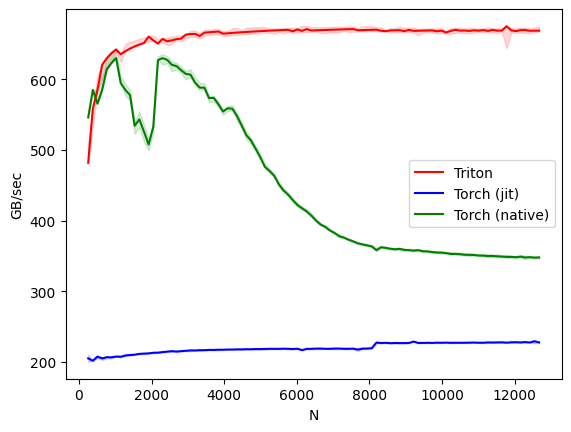

softmax-performance-plot:
          N      Triton  Torch (jit)  Torch (native)
0     256.0  481.882344   204.800005      546.133347
1     384.0  558.545450   201.442627      585.142862
2     512.0  585.142849   207.392411      565.574964
3     640.0  620.606056   204.800005      585.142842
4     768.0  630.153868   206.521014      614.400016
..      ...         ...          ...             ...
93  12160.0  669.741824   227.422561      348.986550
94  12288.0  669.873949   227.885253      347.671088
95  12416.0  668.875440   227.295189      348.213861
96  12544.0  669.013302   229.114161      347.539410
97  12672.0  669.062254   227.427936      347.773576

[98 rows x 4 columns]


In [4]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["N"],
        x_vals=[128 * x for x in range(2, 100)],
        line_arg="provider",
        line_vals=["triton", "torch-jit", "torch-native"],
        line_names=["Triton", "Torch (jit)", "Torch (native)"],
        styles=[("red", "-"), ("blue", "-"), ("green", "-")],
        ylabel="GB/sec",
        plot_name="softmax-performance-plot",
        args={"M": 4096},
    )
)
def benchmark(M, N, provider):
    x = torch.randn(M, N, device="cuda", dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]

    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: softmax(x), quantiles=quantiles
        )
    if provider == "torch-jit":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: naive_softmax(x), quantiles=quantiles
        )
    if provider == "torch-native":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: torch.softmax(x, axis=1), quantiles=quantiles
        )

    gbps = lambda ms: 2 * (x.numel() * x.element_size() / ms) * 1e-6
    return gbps(ms), gbps(min_ms), gbps(max_ms)


benchmark.run(show_plots=True, print_data=True)